<a href="https://colab.research.google.com/github/aspabhi31/PortfolioProjects/blob/main/bert_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import numpy as np
import pandas as pd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset Credits

This dataset is taken from UCI Machine Learning Respository: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

Refer to dataset_credits_readme.txt file for credits details.

### Data Load

In [ ]:
df = pd.read_csv("/content/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.Category = df.Category.map({'ham':0, 'spam': 1})
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.Category.value_counts()

,count
Category,
0,4825
1,747


In [ ]:
df_spam = df[df.Category==1]
df_spam.shape

(747, 2)

In [ ]:
df_ham_small = df[df.Category==0].sample(1000)
df_ham_small.shape

(1000, 2)

In [ ]:
df_small = pd.concat([df_spam, df_ham_small])
df_small.Category.value_counts()

,count
Category,
0,1000
1,747


### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_small.Message,df_small.Category, test_size=0.2, random_state=5)

In [ ]:
y_train[:4]

,Category
3642,1
3528,0
33,0
19,1


In [ ]:
y_train.value_counts()

,count
Category,
0,789
1,608


In [ ]:
y_test.value_counts()

,count
Category,
0,211
1,139


### Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
    return encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels, dtype=torch.float)

tokenize_function(["Hurry up, click here", "I will see you tomorrow"], [1,0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(tensor([[  101,  9241,  2039,  1010, 11562,  2182,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

In [ ]:
X_train.values.tolist()[:2]

['You can stop further club tones by replying "STOP MIX" See my-tone.com/enjoy. html for terms. Club tones cost GBP4.50/week. MFL, PO Box 1146 MK45 2WT (2/3)',
 'Should i send you naughty pix? :)']

In [ ]:
y_train.head(3)

,Category
3642,1
3528,0
33,0


In [ ]:
train_input_ids, train_attention_mask, train_labels = tokenize_function(X_train.values.tolist(), y_train.values.tolist())
val_input_ids, val_attention_mask, val_labels = tokenize_function(X_test.values.tolist(), y_test.values.tolist())

In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, val_labels)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')
bert.config.hidden_size

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

768

### Define Model

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        for param in self.bert.parameters():
            param.requires_grad = False # Freeze all BERT layers

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embedding = bert_output.last_hidden_state[:,0,:]
        return self.classifier(sentence_embedding)

In [ ]:
model = SentimentClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

### Training

In [ ]:
epochs = 2

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f"Batch: {batch}, Epoch: {epoch}, Loss:  {loss.item():0.2f}")
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

Batch: 0, Epoch: 0, Loss:  0.72
Batch: 1, Epoch: 0, Loss:  0.65
Batch: 2, Epoch: 0, Loss:  0.68
Batch: 3, Epoch: 0, Loss:  0.54
Batch: 4, Epoch: 0, Loss:  0.51
Batch: 5, Epoch: 0, Loss:  0.48
Batch: 6, Epoch: 0, Loss:  0.47
Batch: 7, Epoch: 0, Loss:  0.36
Batch: 8, Epoch: 0, Loss:  0.30
Batch: 9, Epoch: 0, Loss:  0.26
Batch: 10, Epoch: 0, Loss:  0.27
Batch: 11, Epoch: 0, Loss:  0.24
Batch: 12, Epoch: 0, Loss:  0.18
Batch: 13, Epoch: 0, Loss:  0.17
Batch: 14, Epoch: 0, Loss:  0.17
Batch: 15, Epoch: 0, Loss:  0.19
Batch: 16, Epoch: 0, Loss:  0.13
Batch: 17, Epoch: 0, Loss:  0.11
Batch: 18, Epoch: 0, Loss:  0.14
Batch: 19, Epoch: 0, Loss:  0.16
Batch: 20, Epoch: 0, Loss:  0.14
Batch: 21, Epoch: 0, Loss:  0.09
Epoch 1/2, Training Loss: 0.31602930108254607
Batch: 0, Epoch: 1, Loss:  0.11
Batch: 1, Epoch: 1, Loss:  0.13
Batch: 2, Epoch: 1, Loss:  0.07
Batch: 3, Epoch: 1, Loss:  0.09
Batch: 4, Epoch: 1, Loss:  0.05
Batch: 5, Epoch: 1, Loss:  0.12
Batch: 6, Epoch: 1, Loss:  0.26
Batch: 7, Epoc

### Evaluation

In [ ]:
# Evaluation
model.eval()
total_val_loss = 0
correct_predictions = 0
predictions=[]
with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device, dtype=torch.float)

        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels.view_as(outputs))
        total_val_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_predictions += torch.sum(preds == labels)
        predictions.extend(preds.cpu().numpy())

avg_val_loss = total_val_loss / len(val_loader)
val_accuracy = correct_predictions.double() / len(val_dataset)
print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.0853989467335244, Validation Accuracy: 0.9686


### Inference

In [ ]:
def predict(model, text, max_length=128):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize input text
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask).squeeze()
        prediction = (output > 0.5).float().item()
        return 'spam' if prediction == 1 else 'ham'

In [ ]:
predict(model, "This is your last chance to WIN cash. Click this link")

'spam'

In [ ]:
predict(model, "Dear Dhaval, I hope to see you on Monday")

'ham'

In [ ]:
predict(model, "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.")

'spam'

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = np.array(predictions)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.9686
Precision: 0.9776
Recall: 0.9424
F1-Score: 0.9597


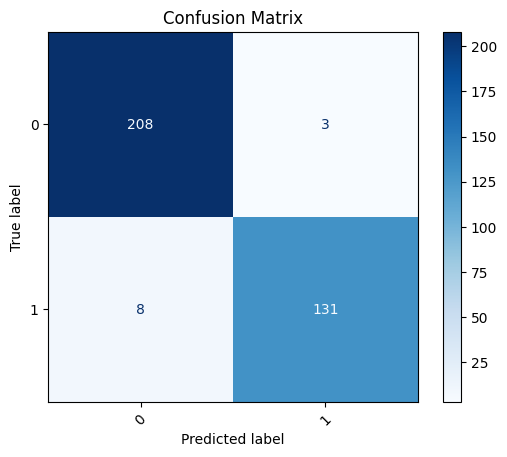

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()